In [1]:
import os
import math
from pathlib import Path
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler

In [2]:
scores_df=pd.read_csv('scores_df.csv')
scores_h=pd.read_csv('scores_hl(1).csv')
human_labeled=pd.read_csv('labeled.csv')
raw_data=pd.read_csv('raw_data.csv')

In [3]:
human_labeled.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1,inplace=True)

In [4]:
RANDOM_SEED=0
def generate_evaluation_dictionary(y,y_pred,y_score):
    # generate evalution dictionary
    output_dict=dict()
    output_dict['accuracy']=metrics.accuracy_score(y,y_pred)
    output_dict['roc_auc']=metrics.roc_auc_score(y,y_score[:,1])
    output_dict['f1']=metrics.f1_score(y,y_pred)
    output_dict['precision']=metrics.precision_score(y,y_pred,average='weighted')
    output_dict['recall']=metrics.recall_score(y,y_pred)
    return output_dict

def run_grid_search_cv( X_train,y_train,model,param_grid):
    # run grid search cross validation
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
    grid.fit(X_train,y_train)
    clf=grid.best_estimator_
    return clf

# Entertaining

## Labelling

In [5]:
scores_df['label']=2
scores_h['label']=-1
for i,r in scores_h.iterrows():
    if 'funny' in human_labeled.entertaining[i]:
        scores_h.loc[i,'label']=1
 
df_all = pd.concat([scores_df,scores_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:521])
df_std=df_all.copy()
df_std.iloc[:,:521]=standard_transform.transform(df_all.iloc[:,:521])

In [6]:
labeled_data=df_std.iloc[-200:,:]

## Feature Selection

In [7]:
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:521], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
yamnet_important_features=df_std.columns[:521][model.get_support()]
print('Number of features selected %d' %len(yamnet_important_features)) 

Number of features selected 211


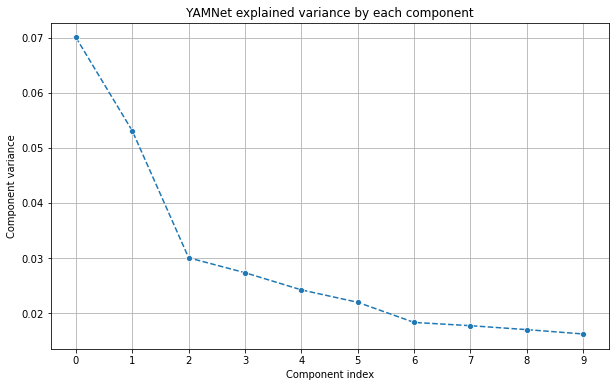

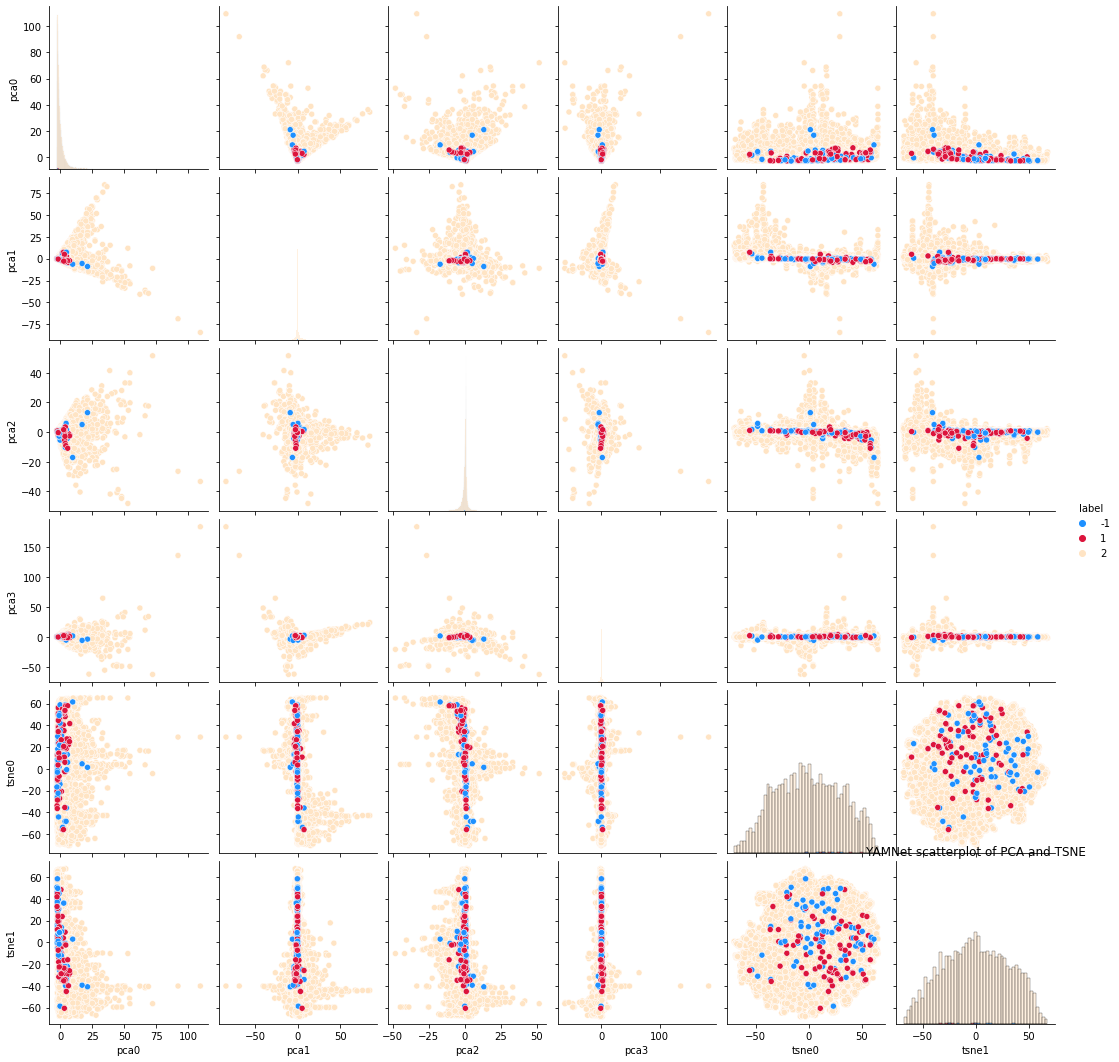

In [8]:
standardised_input = df_std[yamnet_important_features]
pca= PCA(n_components=10, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(standardised_input)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(10),y=pca.explained_variance_ratio_,marker='o',linestyle='--')
plt.grid()
plt.xlabel('Component index')
plt.xticks(np.arange(0, 10, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Component variance')
plt.title('YAMNet explained variance by each component')
plt.savefig("pca_yamnet_e.png")
pca_result_split = np.split(pca_result, 10, axis=1)
for component in range(4):
        df_std["pca" + str(component)] = pca_result_split[component]

        
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, random_state=1)
tsne_result = tsne.fit_transform(standardised_input)
tsne_result_split = np.split(tsne_result, 2, axis=1)
for component in range(2):
        df_std["tsne" + str(component)] = tsne_result_split[component]
sns.pairplot(df_std,vars=["pca0","pca1","pca2","pca3",'tsne0','tsne1'],palette=['dodgerblue','crimson','bisque'],hue='label',kind="scatter",diag_kind="hist")
plt.title('YAMNet scatterplot of PCA and TSNE')
plt.savefig("PCATSNE_yamnet.png")


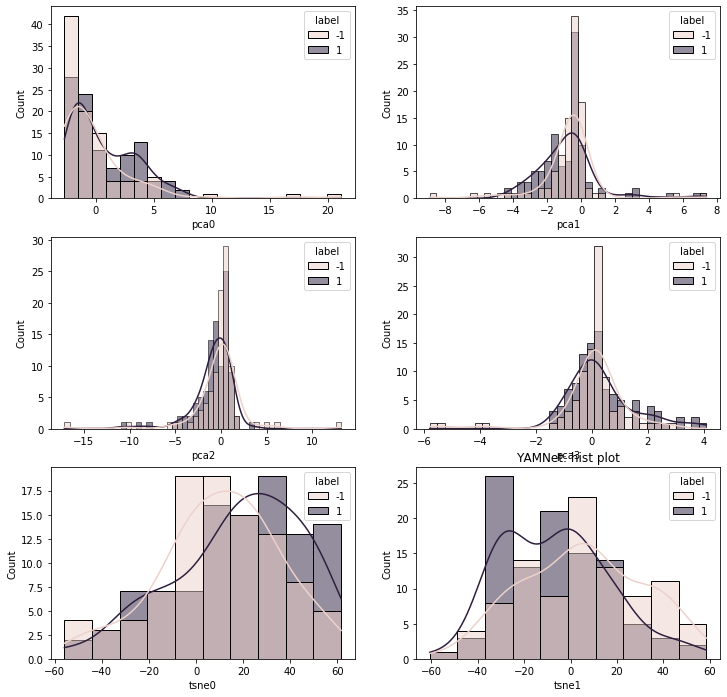

In [9]:
fig, ax_arr = plt.subplots(3,2, figsize=(12,12))

sns.histplot(df_std.iloc[-200:,:],x='pca0',hue='label',kde=True,ax = ax_arr[0][0])
sns.histplot(df_std.iloc[-200:,:],x='pca1',hue='label',kde=True,ax = ax_arr[0][1])
sns.histplot(df_std.iloc[-200:,:],x='pca2',hue='label',kde=True,ax = ax_arr[1][0])
sns.histplot(df_std.iloc[-200:,:],x='pca3',hue='label',kde=True,ax = ax_arr[1][1])
sns.histplot(df_std.iloc[-200:,:],x='tsne0',hue='label',kde=True,ax = ax_arr[2][0])
sns.histplot(df_std.iloc[-200:,:],x='tsne1',hue='label',kde=True,ax = ax_arr[2][1])
plt.title('YAMNet: hist plot')
plt.savefig("hist_yamnet.png")


## PCA and TSNE

In [10]:
# Standardise features

df_PCA_TSNE=df_std.loc[:,['label',"pca0","pca1","pca2",'tsne0','tsne1']]
df_PCA_TSNE.iloc[:,1:]=StandardScaler().fit_transform(df_PCA_TSNE.iloc[:,1:])

#Divide manually labelled data and unlabelled data
labeled_data=df_PCA_TSNE.iloc[-200:,:]
unlabeled_data=df_PCA_TSNE.iloc[:-200, 1:]

#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [11]:
baseline_dic=dict()

### Baseline SVC rbf

In [12]:
np.logspace(1, 6, 6)

array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

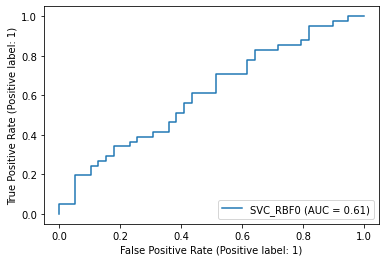

In [13]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.arange(0.01, 1, 0.2)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

### Baseline SVC poly

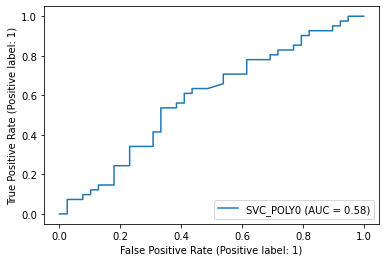

In [14]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(1,10,2)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

### Baseline Random Forest

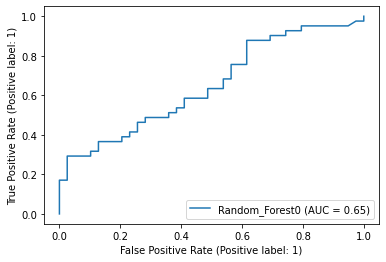

In [15]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(50,60,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

### Baseline NaiveBayes

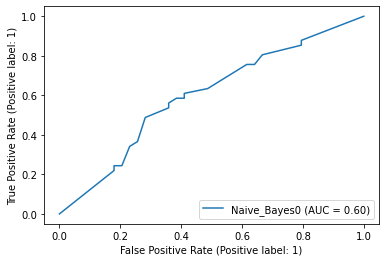

In [16]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=BernoulliNB().fit(X_train,y_train)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

### Generate evaluation table

In [17]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.5625,0.606629,0.597701,0.5621,0.634146
SVC_poly,0.5625,0.584115,0.606742,0.5625,0.658537
random_forest,0.5625,0.651345,0.606742,0.5625,0.658537
Naive_bayes,0.5875,0.597874,0.592593,0.587812,0.585366


## Raw reduced features

In [18]:
# Standardise features
df_raw_reduced=df_std[yamnet_important_features]
df_raw_reduced.insert(0,'label', df_std.label)

#Divide manually labelled data and unlabelled data
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]

#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [19]:
baseline_dic=dict()

### Baseline SVC rbf

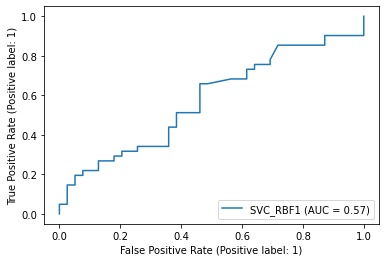

In [20]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.arange(100,10000,2000)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

### Baseline SVC poly

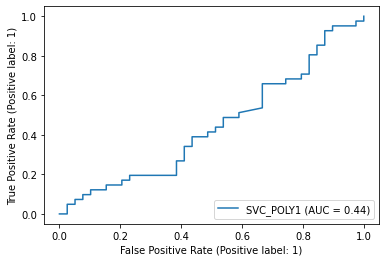

In [21]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 2, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

### Baseline Random Forest

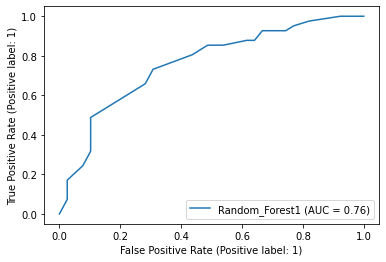

In [22]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,10,2) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

### Baseline NaiveBayes

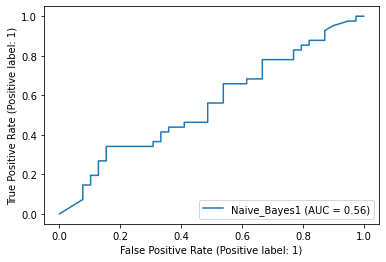

In [23]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=BernoulliNB().fit(X_train,y_train)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

### Generate evaluation table

In [24]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.5375,0.573483,0.626263,0.539832,0.756098
SVC_poly,0.55,0.444966,0.581395,0.549365,0.609756
random_forest,0.6875,0.759537,0.725275,0.69575,0.804878
Naive_bayes,0.525,0.555972,0.486486,0.528482,0.439024


## Plot ROC

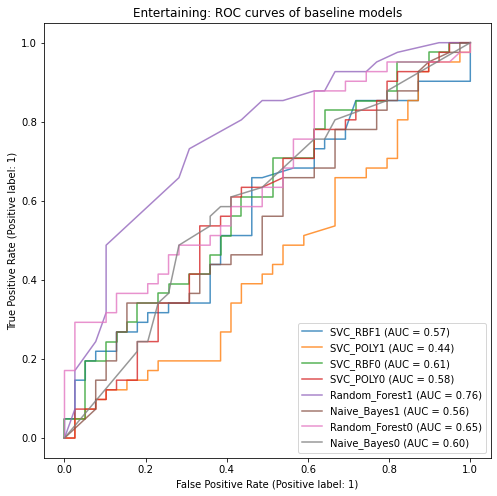

In [25]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf1.plot(ax=ax,alpha=0.8)
svc_disp_poly1.plot(ax=ax,alpha=0.8)
svc_disp_rbf0.plot(ax=ax,alpha=0.8)
svc_disp_poly0.plot(ax=ax,alpha=0.8)

rf_disp1.plot(ax=ax,alpha=0.8)
nb_disp_poly1.plot(ax=ax,alpha=0.8)
rf_disp0.plot(ax=ax,alpha=0.8)
nb_disp_poly0.plot(ax=ax,alpha=0.8)

plt.title('Entertaining: ROC curves of baseline models')
plt.savefig('ROC_all_e_y')

# Subjective

## Labelling

In [26]:
scores_df['label']=2
scores_h['label']=-1
for i,r in scores_h.iterrows():
    if 'pproval' in human_labeled.subjective[i] :
        scores_h.loc[i,'label']=1
df_all = pd.concat([scores_df,scores_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:521])
df_std=df_all.copy()
df_std.iloc[:,:521]=standard_transform.transform(df_all.iloc[:,:521])

In [27]:
labeled_data=df_std.iloc[-200:,:]
labeled_data.label.value_counts()

-1    106
 1     94
Name: label, dtype: int64

## Feature Selection

In [28]:
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:521], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
yamnet_important_features=df_std.columns[:521][model.get_support()]
print('Number of features selected %d' %len(yamnet_important_features)) 

Number of features selected 208


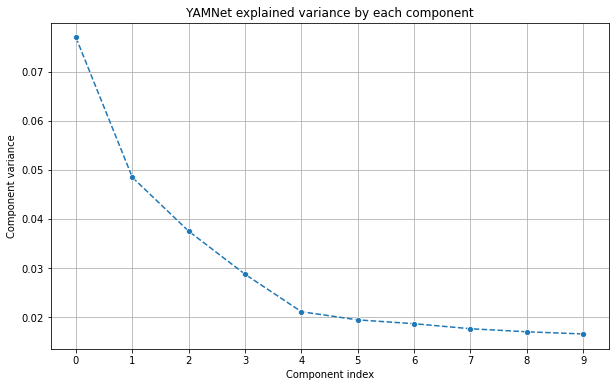

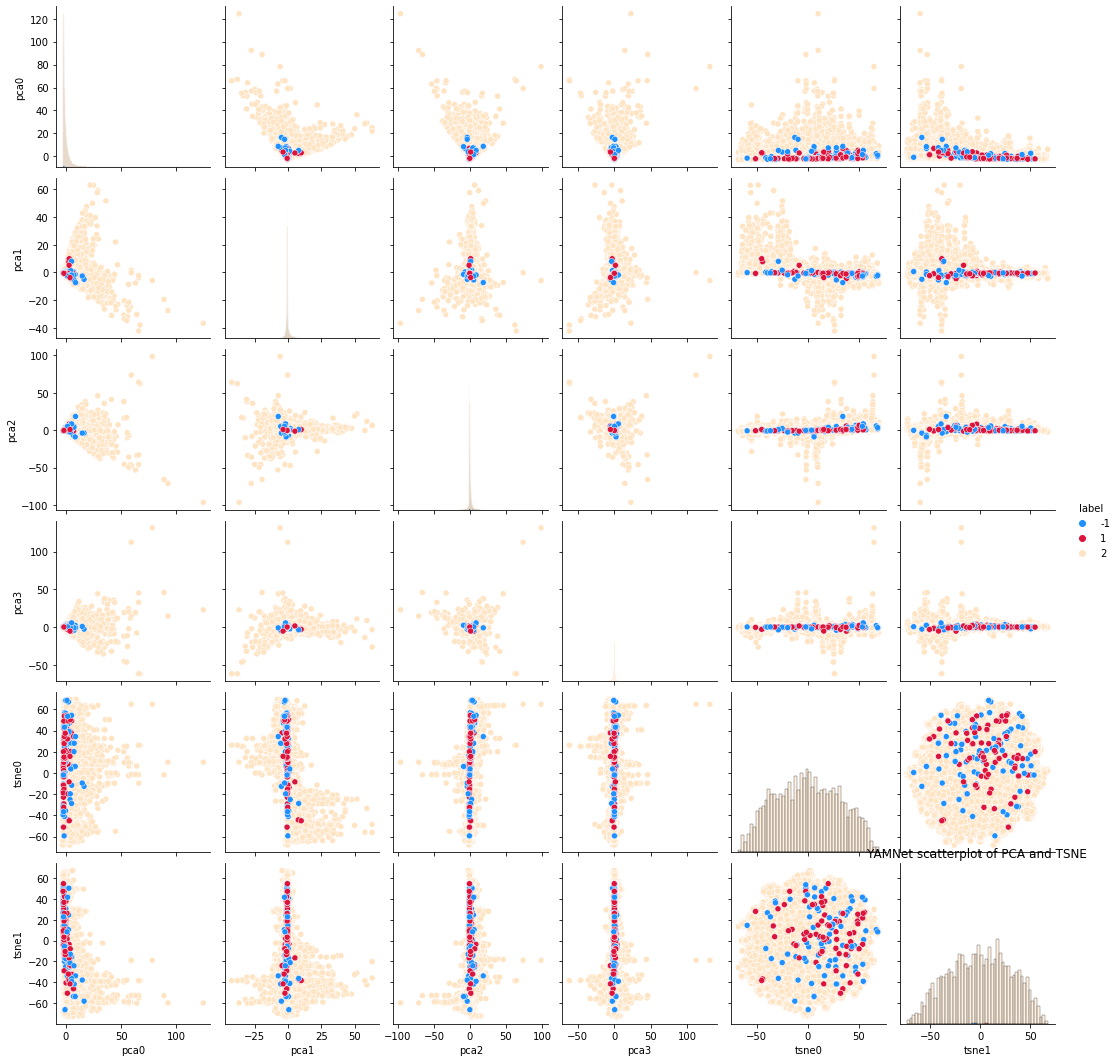

In [29]:
standardised_input = df_std[yamnet_important_features]
pca= PCA(n_components=10, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(standardised_input)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(10),y=pca.explained_variance_ratio_,marker='o',linestyle='--')
plt.grid()
plt.xlabel('Component index')
plt.xticks(np.arange(0, 10, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Component variance')
plt.title('YAMNet explained variance by each component')
plt.savefig("pca_yamnet_s.png")
pca_result_split = np.split(pca_result, 10, axis=1)
for component in range(4):
        df_std["pca" + str(component)] = pca_result_split[component]

        
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, random_state=1)
tsne_result = tsne.fit_transform(standardised_input)
tsne_result_split = np.split(tsne_result, 2, axis=1)
for component in range(2):
        df_std["tsne" + str(component)] = tsne_result_split[component]
sns.pairplot(df_std,vars=["pca0","pca1","pca2","pca3",'tsne0','tsne1'],palette=['dodgerblue','crimson','bisque'],hue='label',kind="scatter",diag_kind="hist")
plt.title('YAMNet scatterplot of PCA and TSNE')
plt.savefig("PCATSNE_yamnet.png")


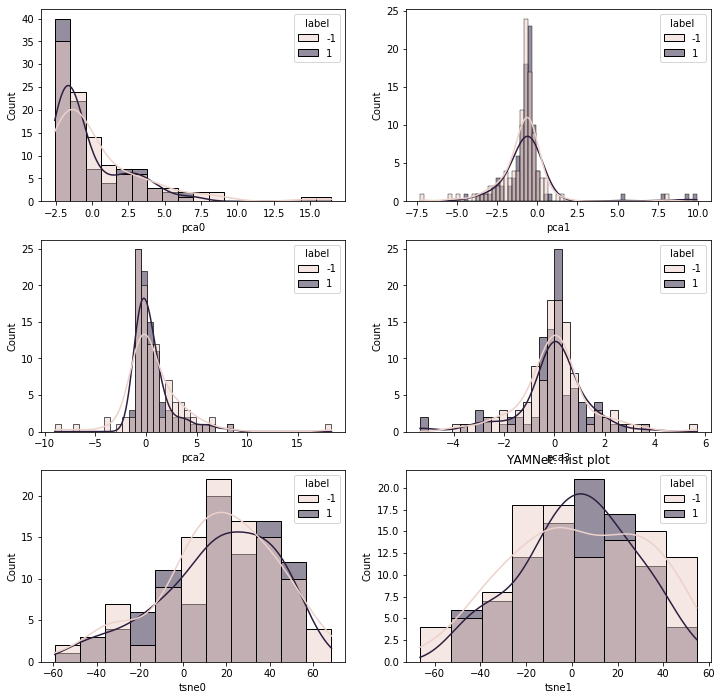

In [30]:
fig, ax_arr = plt.subplots(3,2, figsize=(12,12))

sns.histplot(df_std.iloc[-200:,:],x='pca0',hue='label',kde=True,ax = ax_arr[0][0])
sns.histplot(df_std.iloc[-200:,:],x='pca1',hue='label',kde=True,ax = ax_arr[0][1])
sns.histplot(df_std.iloc[-200:,:],x='pca2',hue='label',kde=True,ax = ax_arr[1][0])
sns.histplot(df_std.iloc[-200:,:],x='pca3',hue='label',kde=True,ax = ax_arr[1][1])
sns.histplot(df_std.iloc[-200:,:],x='tsne0',hue='label',kde=True,ax = ax_arr[2][0])
sns.histplot(df_std.iloc[-200:,:],x='tsne1',hue='label',kde=True,ax = ax_arr[2][1])
plt.title('YAMNet: hist plot')
plt.savefig("hist_yamnet.png")


## PCA and TSNE

In [31]:
# Standardise features
df_PCA_TSNE=df_std.loc[:,['label',"pca0","pca1",'tsne0','tsne1']]
df_PCA_TSNE.iloc[:,1:]=StandardScaler().fit_transform(df_PCA_TSNE.iloc[:,1:])
#
labeled_data=df_PCA_TSNE.iloc[-200:,:]
unlabeled_data=df_PCA_TSNE.iloc[:-200, 1:]

np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [32]:
baseline_dic=dict()

### Baseline SVC rbf

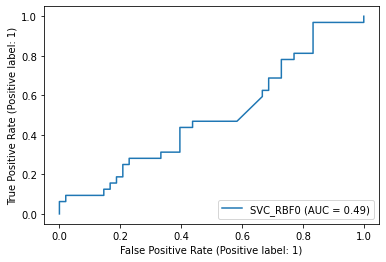

In [33]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.arange(10,1000,200)
gamma_range = np.logspace(-5, 3, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

### Baseline SVC poly

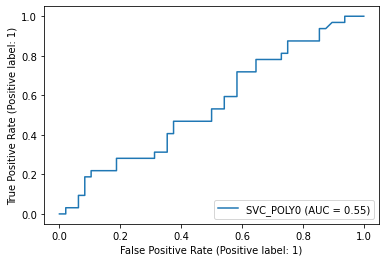

In [34]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

### Baseline Random Forest

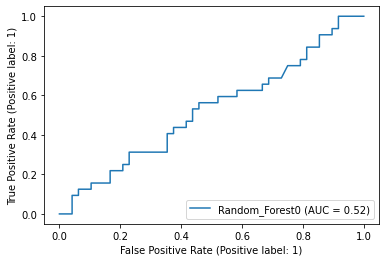

In [35]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

### Baseline NaiveBayes

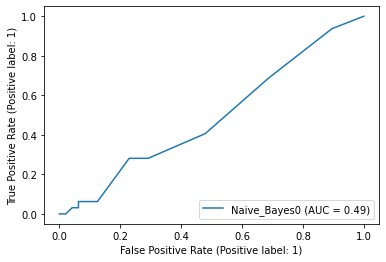

In [36]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

### Generate evaluation table

In [37]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.45,0.494141,0.405405,0.474436,0.46875
SVC_poly,0.4875,0.547852,0.422535,0.505066,0.46875
random_forest,0.5375,0.522786,0.493151,0.560225,0.5625
Naive_bayes,0.4625,0.488932,0.505747,0.52,0.6875


## Raw reduced features

In [38]:
# Standardise features
df_raw_reduced=df_std[yamnet_important_features]
df_raw_reduced.insert(0,'label', df_std.label)
#Divide manually labelled data and unlabelled data
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [39]:
baseline_dic=dict()

### Baseline SVC rbf

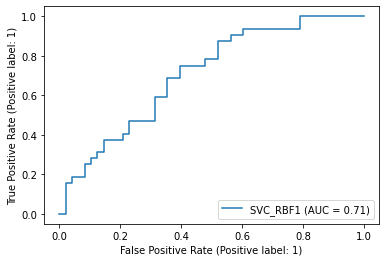

In [40]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

### Baseline SVC poly

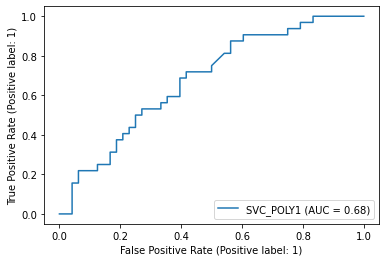

In [41]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

### Baseline Random Forest

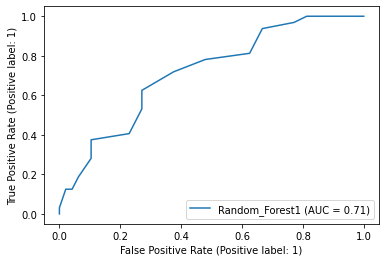

In [42]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(1,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

### Baseline NaiveBayes

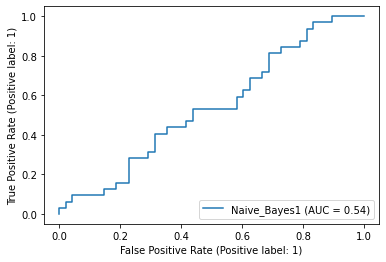

In [43]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

### Generate evaluation table

In [44]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.6125,0.70638,0.607595,0.658801,0.75
SVC_poly,0.6,0.677734,0.6,0.65,0.75
random_forest,0.6625,0.714193,0.630137,0.685929,0.71875
Naive_bayes,0.4875,0.537109,0.506024,0.53712,0.65625


## Plot ROC

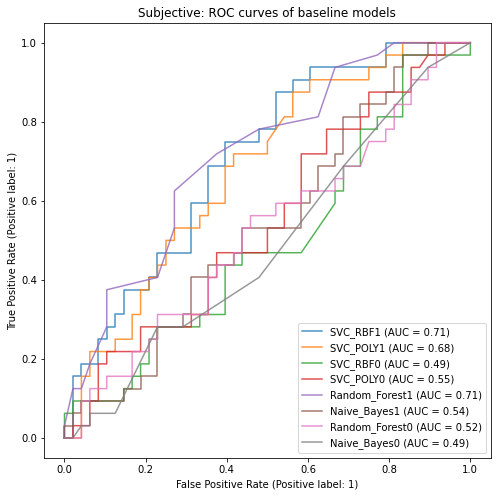

In [45]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf1.plot(ax=ax,alpha=0.8)
svc_disp_poly1.plot(ax=ax,alpha=0.8)
svc_disp_rbf0.plot(ax=ax,alpha=0.8)
svc_disp_poly0.plot(ax=ax,alpha=0.8)

rf_disp1.plot(ax=ax,alpha=0.8)
nb_disp_poly1.plot(ax=ax,alpha=0.8)
rf_disp0.plot(ax=ax,alpha=0.8)
nb_disp_poly0.plot(ax=ax,alpha=0.8)

plt.title('Subjective: ROC curves of baseline models')
plt.savefig('ROC_all_s_y')

# Discussion

## Labelling

In [46]:
scores_df['label']=2
scores_h['label']=-1
for i,r in scores_h.iterrows():
    if 'debate' in human_labeled.discussion[i] or  'conversation' in human_labeled.discussion[i]:
        scores_h.loc[i,'label']=1
 
df_all = pd.concat([scores_df,scores_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:521])
df_std=df_all.copy()
df_std.iloc[:,:521]=standard_transform.transform(df_all.iloc[:,:521])

In [47]:
labeled_data=df_std.iloc[-200:,:]
labeled_data.label.value_counts()

 1    154
-1     46
Name: label, dtype: int64

## Feature Selection

In [48]:
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:521], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
yamnet_important_features=df_std.columns[:521][model.get_support()]
print('Number of features selected %d' %len(yamnet_important_features)) 

Number of features selected 225


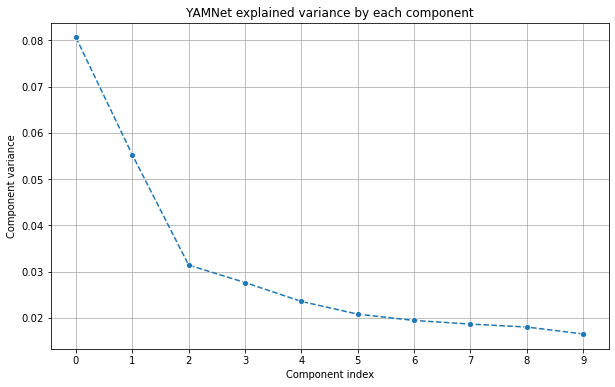

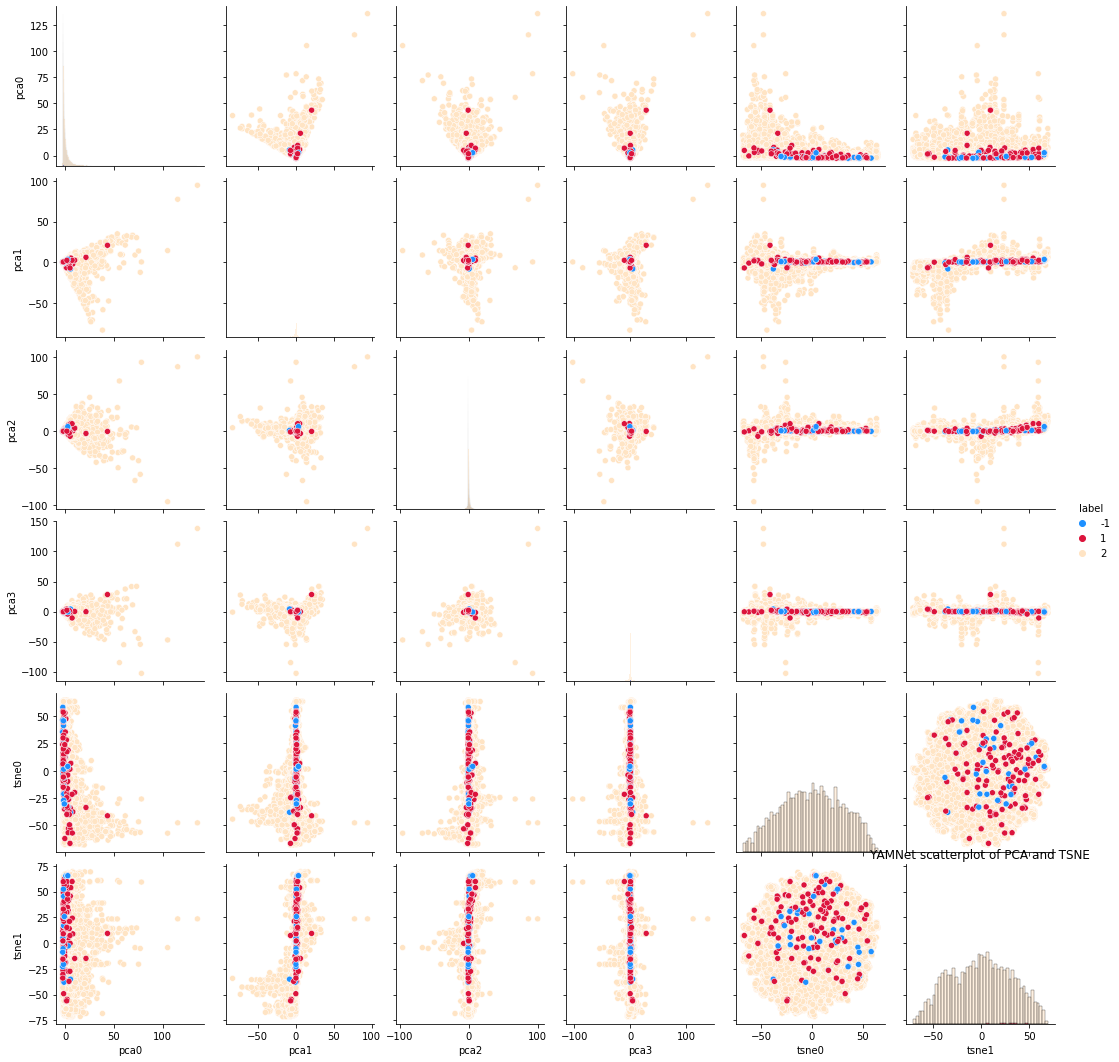

In [49]:
standardised_input = df_std[yamnet_important_features]
pca= PCA(n_components=10, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(standardised_input)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(10),y=pca.explained_variance_ratio_,marker='o',linestyle='--')
plt.grid()
plt.xlabel('Component index')
plt.xticks(np.arange(0, 10, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Component variance')
plt.title('YAMNet explained variance by each component')
plt.savefig("pca_yamnet_d.png")
pca_result_split = np.split(pca_result, 10, axis=1)
for component in range(4):
        df_std["pca" + str(component)] = pca_result_split[component]

        
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, random_state=1)
tsne_result = tsne.fit_transform(standardised_input)
tsne_result_split = np.split(tsne_result, 2, axis=1)
for component in range(2):
        df_std["tsne" + str(component)] = tsne_result_split[component]
sns.pairplot(df_std,vars=["pca0","pca1","pca2","pca3",'tsne0','tsne1'],palette=['dodgerblue','crimson','bisque'],hue='label',kind="scatter",diag_kind="hist")
plt.title('YAMNet scatterplot of PCA and TSNE')
plt.savefig("PCATSNE_yamnet.png")


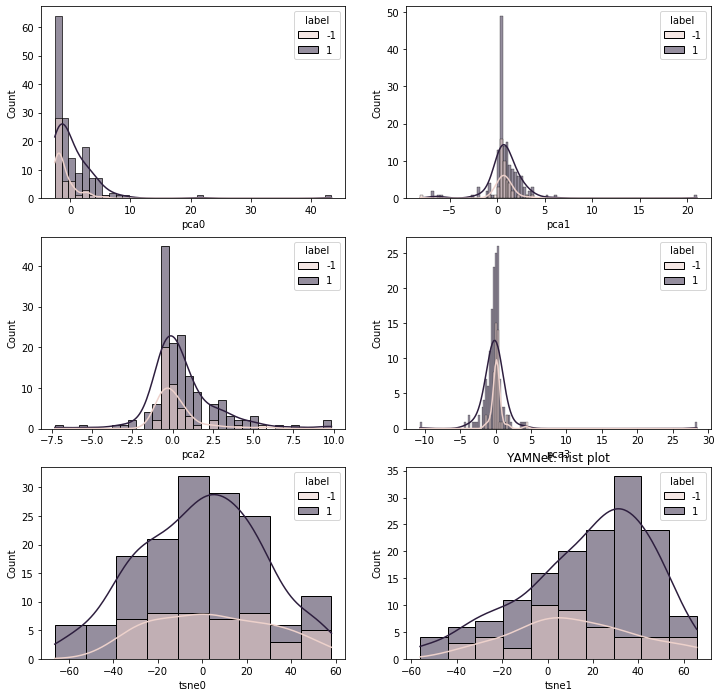

In [50]:
fig, ax_arr = plt.subplots(3,2, figsize=(12,12))

sns.histplot(df_std.iloc[-200:,:],x='pca0',hue='label',kde=True,ax = ax_arr[0][0])
sns.histplot(df_std.iloc[-200:,:],x='pca1',hue='label',kde=True,ax = ax_arr[0][1])
sns.histplot(df_std.iloc[-200:,:],x='pca2',hue='label',kde=True,ax = ax_arr[1][0])
sns.histplot(df_std.iloc[-200:,:],x='pca3',hue='label',kde=True,ax = ax_arr[1][1])
sns.histplot(df_std.iloc[-200:,:],x='tsne0',hue='label',kde=True,ax = ax_arr[2][0])
sns.histplot(df_std.iloc[-200:,:],x='tsne1',hue='label',kde=True,ax = ax_arr[2][1])
plt.title('YAMNet: hist plot')
plt.savefig("hist_yamnet.png")


## PCA and TSNE

In [51]:
# Standardise features
df_PCA_TSNE=df_std.loc[:,['label',"pca0","pca1","pca2",'tsne0','tsne1']]
df_PCA_TSNE.iloc[:,1:]=StandardScaler().fit_transform(df_PCA_TSNE.iloc[:,1:])
#Divide manually labelled data and unlabelled data
labeled_data=df_PCA_TSNE.iloc[-200:,:]
unlabeled_data=df_PCA_TSNE.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [52]:
baseline_dic=dict()

### Baseline SVC rbf

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


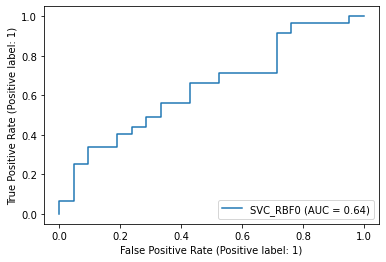

In [53]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 4, 6)
gamma_range = np.logspace(-10, -2, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

### Baseline SVC poly

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


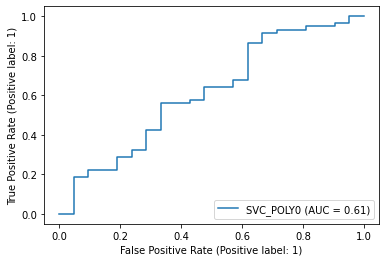

In [62]:
#Initialise the model with balanced weight and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(5,15,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range,coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

### Baseline Random Forest

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


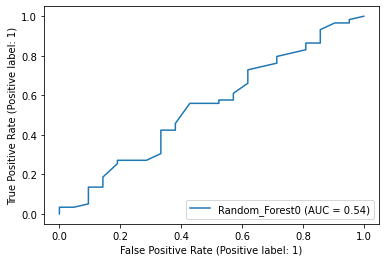

In [64]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(1,20,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

### Baseline NaiveBayes

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


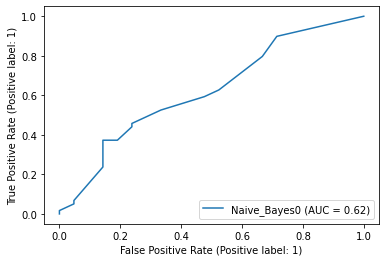

In [65]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=model.fit(X_train,y_train)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

### Generate evaluation table

In [66]:
# Unbalanced result
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.7375,0.638418,0.848921,0.543906,1.0
SVC_poly,0.7375,0.610977,0.848921,0.543906,1.0
random_forest,0.7375,0.543584,0.848921,0.543906,1.0
Naive_bayes,0.7375,0.622276,0.848921,0.543906,1.0


### Over-sampling

In [67]:
# Over-sampling the training set
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
baseline_dic_balanced=dict()

#### Baseline SVC rbf

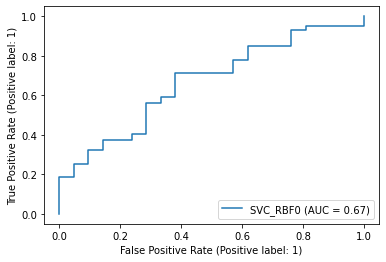

In [68]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 4, 6)
gamma_range = np.logspace(-10, -2, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

#### Baseline SVC poly

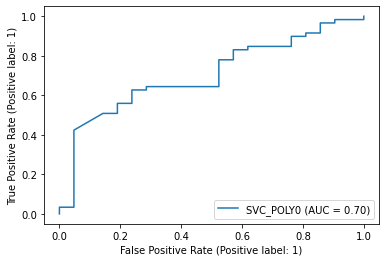

In [69]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(5,15,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range,coef0=coef0_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

#### Baseline Random Forest

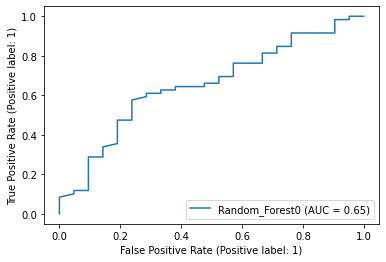

In [70]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
#Evaluate model
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

#### Baseline NaiveBayes

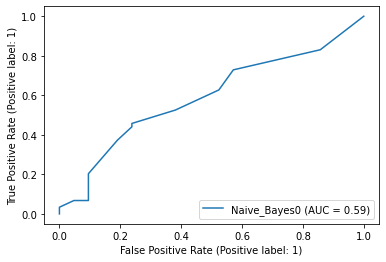

In [71]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=model.fit(X_resampled, y_resampled)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

#### Generate evaluation table

In [72]:
baseline_df_balanced=pd.DataFrame(index=baseline_dic_balanced['SVC_rbf'].keys(),columns=baseline_dic_balanced.keys())
for i in baseline_df_balanced.columns:
    for j in baseline_dic[i]:
        baseline_df_balanced.loc[j,i]=baseline_dic_balanced[i][j][0]
baseline_df_balanced=baseline_df_balanced.T
baseline_df_balanced

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.6875,0.665052,0.770642,0.73325,0.711864
SVC_poly,0.7125,0.703793,0.806723,0.708125,0.813559
random_forest,0.725,0.652542,0.828125,0.685804,0.898305
Naive_bayes,0.5375,0.590799,0.593407,0.709766,0.457627


## Raw reduced features

In [73]:
# Standardise features
df_raw_reduced=df_std[yamnet_important_features]
df_raw_reduced.insert(0,'label', df_std.label)
#Divide manually labelled data and unlabelled data
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [74]:
baseline_dic=dict()

### Baseline SVC rbf

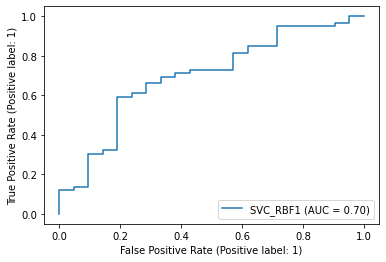

In [75]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

### Baseline SVC poly

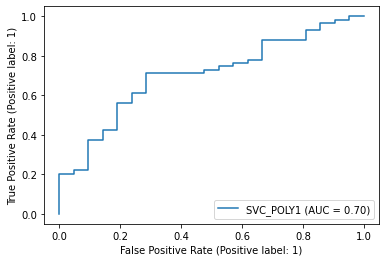

In [76]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(5,15,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range,coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

### Baseline Random Forest

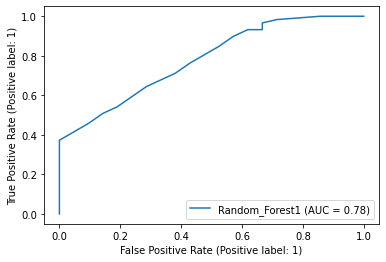

In [77]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(25,50,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

### Baseline NaiveBayes

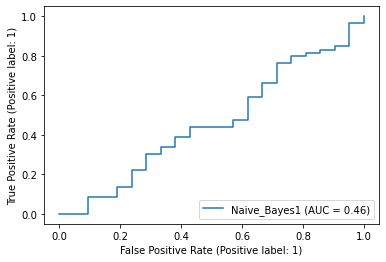

In [78]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

### Generate evaluation table

In [79]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.75,0.695722,0.855072,0.813291,1.0
SVC_poly,0.75,0.703793,0.855072,0.813291,1.0
random_forest,0.8,0.780872,0.876923,0.796244,0.966102
Naive_bayes,0.6375,0.458434,0.775194,0.553036,0.847458


### Over-sampling

In [80]:
# Over-sampling the training set
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
baseline_dic_balanced=dict()

#### Baseline SVC rbf

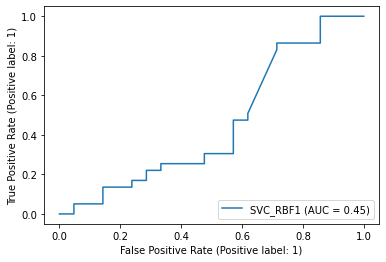

In [81]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

#### Baseline SVC poly

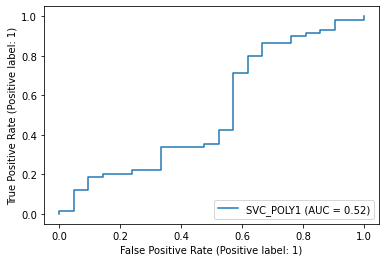

In [82]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(5,15,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range,coef0=coef0_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

#### Baseline Random Forest

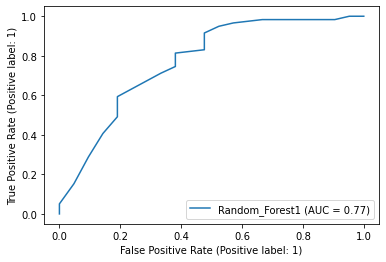

In [83]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(25,50,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4)  
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
#Evaluate model
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

#### Baseline NaiveBayes

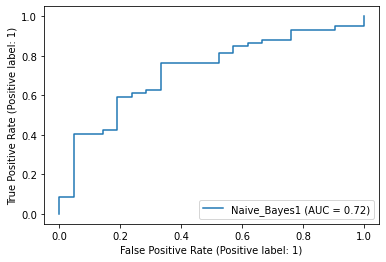

In [85]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

#### Generate evaluation table

In [86]:
baseline_df_balanced=pd.DataFrame(index=baseline_dic_balanced['SVC_rbf'].keys(),columns=baseline_dic_balanced.keys())
for i in baseline_df_balanced.columns:
    for j in baseline_dic[i]:
        baseline_df_balanced.loc[j,i]=baseline_dic_balanced[i][j][0]
baseline_df_balanced=baseline_df_balanced.T
baseline_df_balanced

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.775,0.454399,0.867647,0.827597,1.0
SVC_poly,0.6875,0.519774,0.789916,0.682708,0.79661
random_forest,0.825,0.771186,0.888889,0.818341,0.949153
Naive_bayes,0.5375,0.723164,0.574713,0.749348,0.423729


## Plot ROC

#### raw sampling

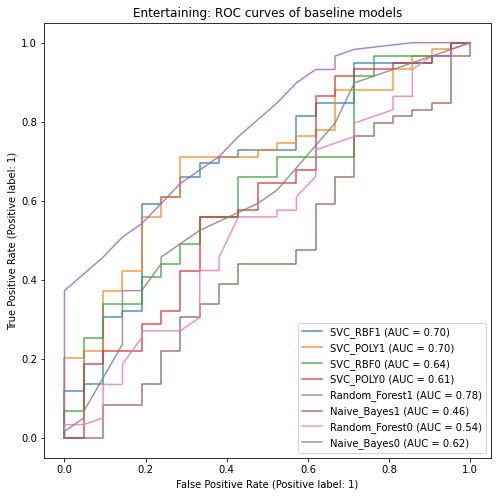

In [87]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf1.plot(ax=ax,alpha=0.8)
svc_disp_poly1.plot(ax=ax,alpha=0.8)
svc_disp_rbf0.plot(ax=ax,alpha=0.8)
svc_disp_poly0.plot(ax=ax,alpha=0.8)

rf_disp1.plot(ax=ax,alpha=0.8)
nb_disp_poly1.plot(ax=ax,alpha=0.8)
rf_disp0.plot(ax=ax,alpha=0.8)
nb_disp_poly0.plot(ax=ax,alpha=0.8)

plt.title('Entertaining: ROC curves of baseline models')
plt.savefig('ROC_all_d_y')

#### over-sampling

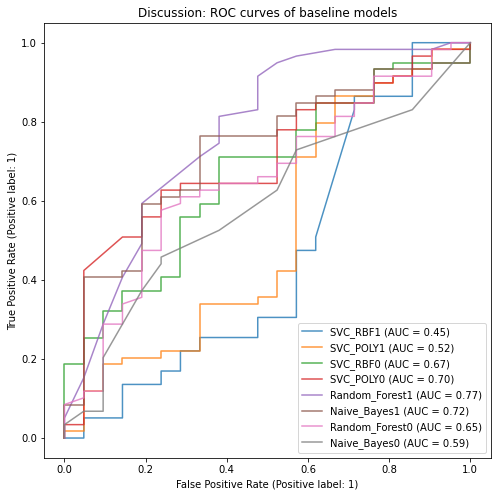

In [89]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf11.plot(ax=ax,alpha=0.8)
svc_disp_poly11.plot(ax=ax,alpha=0.8)
svc_disp_rbf00.plot(ax=ax,alpha=0.8)
svc_disp_poly00.plot(ax=ax,alpha=0.8)

rf_disp11.plot(ax=ax,alpha=0.8)
nb_disp_poly11.plot(ax=ax,alpha=0.8)
rf_disp00.plot(ax=ax,alpha=0.8)
nb_disp_poly00.plot(ax=ax,alpha=0.8)

plt.title('Discussion: ROC curves of baseline models')
plt.savefig('ROC_all_d_y_os')